<a href="https://colab.research.google.com/github/Blueberrylipstick/GymResearch/blob/main/BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Presentation
    General requirements:
    - max 15 min + 5 min questions
    - everyone in a group should present at least one topic

## Technology stack:  
    - pyspark or spark SQL (for at least data preprocessing)
    - python (pandas, numpy, sklearn, etc)
    - git - for collaboration
    - Databricks is optional


## Structure:
- Presentation
    - business objectives & problem description
    - how you setup collaboration process in a team

- Technical part (per area: De, Ds, Da)
    - Describe methods, what was done, tell a story with data ...
    - Summary and lessons learned


## Evaluation
    - Presentation / Story telling
    - Data engineering part
    - Data science / analysis part  

# IMPORTS

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, round
from pyspark.ml.feature import StringIndexer

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv("gym_members_exercise_tracking.csv")

In [4]:
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


# Preprocessing

In [5]:
spark = SparkSession.builder \
    .appName("project") \
    .getOrCreate()

In [6]:
csv_file_path = "gym_members_exercise_tracking.csv"

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

df.show()

df.printSchema()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [7]:
nan_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
nan_counts.show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [8]:
df = df.withColumn("Gender", when(col("Gender") == "Male", 1).otherwise(0))

df = df.withColumn("Calories_Per_Hour", round(col("Calories_Burned") / col("Session_Duration (hours)"),2))

df = df.withColumn("Activity_Index", round(col("Workout_Frequency (days/week)") * col("Session_Duration (hours)"),2))

In [9]:
workout_types = ["Yoga", "HIIT", "Cardio", "Strength"]

for workout in workout_types:
    df = df.withColumn(workout, when(col("Workout_Type") == workout, 1).otherwise(0))

In [10]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
df.coalesce(1).write.option("header", "true").csv("new_gym_members_exercise_tracking.csv")

# EDA

In [11]:
df = pd.read_csv('/content/new_gym_members_exercise_tracking.csv/part-00000-b5f50a7f-9014-46b1-9549-ef144bb89313-c000.csv')
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Calories_Per_Hour,Activity_Index,Yoga,HIIT,Cardio,Strength
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,Yoga,...,3.5,4,3,30.20,776.92,6.76,1,0,0,0
1,46,0,74.9,1.53,179,151,66,1.30,883.0,HIIT,...,2.1,4,2,32.00,679.23,5.20,0,1,0,0
2,32,0,68.1,1.66,167,122,54,1.11,677.0,Cardio,...,2.3,4,2,24.71,609.91,4.44,0,0,1,0
3,25,1,53.2,1.70,190,164,56,0.59,532.0,Strength,...,2.1,3,1,18.41,901.69,1.77,0,0,0,1
4,38,1,46.1,1.79,188,158,68,0.64,556.0,Strength,...,2.8,3,1,14.39,868.75,1.92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,1,87.1,1.74,187,158,67,1.57,1364.0,Strength,...,3.5,4,3,28.77,868.79,6.28,0,0,0,1
969,25,1,66.6,1.61,184,166,56,1.38,1260.0,Strength,...,3.0,2,1,25.69,913.04,2.76,0,0,0,1
970,59,0,60.4,1.76,194,120,53,1.72,929.0,Cardio,...,2.7,5,3,19.50,540.12,8.60,0,0,1,0
971,32,1,126.4,1.83,198,146,62,1.10,883.0,HIIT,...,2.1,3,2,37.74,802.73,3.30,0,1,0,0


In [12]:
df = pd.read_csv('gym_members_exercise_tracking.csv')

In [13]:
fig = px.histogram(df, x='Age', nbins=5, title='Age Distribution', color='Gender')
fig.update_layout(bargap=0.2)
fig.show()

In [14]:
fig = px.scatter(df, x='Weight (kg)', y='Height (m)', color='Gender', title='Weight vs Height')
fig.show()

In [15]:
sport = pd.read_csv('part-00000-b5f50a7f-9014-46b1-9549-ef144bb89313-c000.csv')

Text(0.5, 1.0, 'Correlation Heatmap')

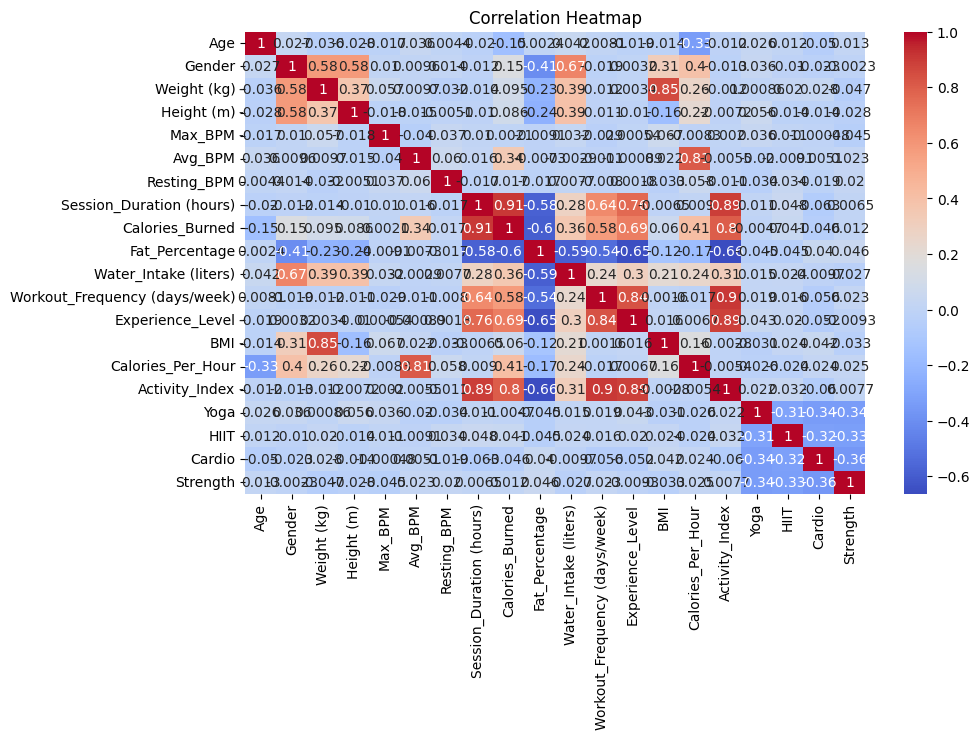

In [16]:
# correlation heatmap
plt.figure(figsize=(10, 6))
numeric_sport = sport.select_dtypes(include=['number'])
sns.heatmap(numeric_sport.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [17]:
# gender = df.groupby(['gender', 'Age'])
male = sport[sport['Gender'] == 1]
female = sport[sport['Gender'] == 0]

In [18]:
fig = px.histogram(df, x = 'Workout_Type', title = 'Workout Types Distribution', color='Gender')
fig.show()

In [19]:
fig = px.histogram(sport, x='Session_Duration (hours)', nbins=10, title='Session duration', color='Gender')
fig.update_layout(bargap=0.2)
fig.show()

In [20]:
fig = px.scatter(sport, x='Session_Duration (hours)', y='Calories_Burned', title='Calories Burned vs Session Duration')
fig.show()

In [21]:
yoga = sport[sport['Yoga'] == 1]
hiit = sport[sport['HIIT'] == 1]
cardio = sport[sport['Cardio'] == 1]
strength = sport[sport['Strength'] == 1]
fig = px.scatter()
fig.add_trace(go.Scatter(x=yoga['Session_Duration (hours)'], y=yoga['Calories_Burned'], mode='markers', name='Yoga'))
fig.add_trace(go.Scatter(x=hiit['Session_Duration (hours)'], y=hiit['Calories_Burned'], mode='markers', name='HIIT'))
fig.add_trace(go.Scatter(x=cardio['Session_Duration (hours)'], y=cardio['Calories_Burned'], mode='markers', name='Cardio'))
fig.add_trace(go.Scatter(x=strength['Session_Duration (hours)'], y=strength['Calories_Burned'], mode='markers', name='Strength'))
fig.update_layout(title='Calories Burned vs Session Duration by Workout Type')

fig.show()

In [22]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Age'], y = sport['Session_Duration (hours)'], mode='markers'))
fig.update_layout(title='Session Duration vs Age')

In [23]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Fat_Percentage'], y = sport['Session_Duration (hours)'], mode='markers'))
fig.update_layout(title='Session Duration vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Session Duration')

In [24]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = male['Fat_Percentage'], y = male['Session_Duration (hours)'], mode='markers',name='Male'))
fig.add_trace(go.Scatter(x = female['Fat_Percentage'], y = female['Session_Duration (hours)'], mode='markers',name='female'))
fig.update_layout(title='Session Duration vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Session Duration')

In [25]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Fat_Percentage'], y = sport['Gender'], mode='markers'))
fig.update_layout(title='Gender vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Gender')

In [26]:
fig = px.box()

fig.add_trace(go.Box(x=sport['Gender'], y=sport['Session_Duration (hours)']))

fig.update_layout(
    title='Session Duration vs Gender',
    xaxis_title='Gender (0-female 1-male)',
    yaxis_title='Session Duration',
    width=600,
    height=600
)

fig.show()

In [27]:
fig = px.box()
fig.add_trace(go.Box(x = sport['Experience_Level'], y = sport['Session_Duration (hours)']))
fig.update_layout(title='Session Duration vs Experience Level', xaxis_title='Experience Level', yaxis_title='Session Duration',width=600,height=600)

In [42]:
# avg calories burn per workout type
avg_calories = df.groupby('Workout_Type')['Calories_Burned'].mean().reset_index()
fig = px.bar(avg_calories, x='Workout_Type', y='Calories_Burned', title='Average Calories Burned per Workout Type')
# fig.update_layout(
#     width=700,  # Set the width
#     height=600  # Set the height
# )
fig.show()

In [29]:
fig = px.histogram(df, 'Workout_Frequency (days/week)', color='Gender')
fig.update_layout(title='Workout Frequency Distribution', bargap=0.2)
fig.show()

In [30]:
fig = px.histogram(df, 'Workout_Frequency (days/week)', color='Experience_Level')
fig.update_layout(title='Workout Frequency Distribution', bargap=0.2)
fig.show()

# Models

In [31]:
sport

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Calories_Per_Hour,Activity_Index,Yoga,HIIT,Cardio,Strength
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,Yoga,...,3.5,4,3,30.20,776.92,6.76,1,0,0,0
1,46,0,74.9,1.53,179,151,66,1.30,883.0,HIIT,...,2.1,4,2,32.00,679.23,5.20,0,1,0,0
2,32,0,68.1,1.66,167,122,54,1.11,677.0,Cardio,...,2.3,4,2,24.71,609.91,4.44,0,0,1,0
3,25,1,53.2,1.70,190,164,56,0.59,532.0,Strength,...,2.1,3,1,18.41,901.69,1.77,0,0,0,1
4,38,1,46.1,1.79,188,158,68,0.64,556.0,Strength,...,2.8,3,1,14.39,868.75,1.92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,1,87.1,1.74,187,158,67,1.57,1364.0,Strength,...,3.5,4,3,28.77,868.79,6.28,0,0,0,1
969,25,1,66.6,1.61,184,166,56,1.38,1260.0,Strength,...,3.0,2,1,25.69,913.04,2.76,0,0,0,1
970,59,0,60.4,1.76,194,120,53,1.72,929.0,Cardio,...,2.7,5,3,19.50,540.12,8.60,0,0,1,0
971,32,1,126.4,1.83,198,146,62,1.10,883.0,HIIT,...,2.1,3,2,37.74,802.73,3.30,0,1,0,0


In [32]:
def make_datasets(data):
    X = data.copy()
    n = len(X)
    split1 = int(n * 0.8)
    Y = X["Calories_Burned"]
    X = X.drop(columns=["Workout_Type", "Calories_Burned"])

    X_train, Y_train = X.iloc[:split1], Y.iloc[:split1]
    X_validate, Y_validate = X.iloc[split1:], Y.iloc[split1:]
    return X_train, Y_train, X_validate, Y_validate

def rmse(predicted, ground):
  return np.linalg.norm(predicted - ground) / np.sqrt(len(ground))

def mape(predicted, ground):
    return np.mean(np.abs((ground - predicted) / ground)) * 100

def plot_p_vs_v(predicted, Y_validate):
  plt.figure(figsize=(15, 10))
  dots = [i for i in range(1, len(predicted)+1)]
  plt.scatter(dots, predicted)
  plt.scatter(dots, Y_validate)
  plt.legend(["Predicted value", "True value"])
  plt.show()

In [33]:
X_train, Y_train, X_validate, Y_validate = make_datasets(sport)

In [34]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, Y_train)
predicted = dt_model.predict(X_validate)
print("Root Mean Squared Error:", rmse(predicted, Y_validate))
print("Mean Absolute Percentage Error (MAPE):", mape(predicted, Y_validate))

Root Mean Squared Error: 47.537515549462455
Mean Absolute Percentage Error (MAPE): 4.111685647243063


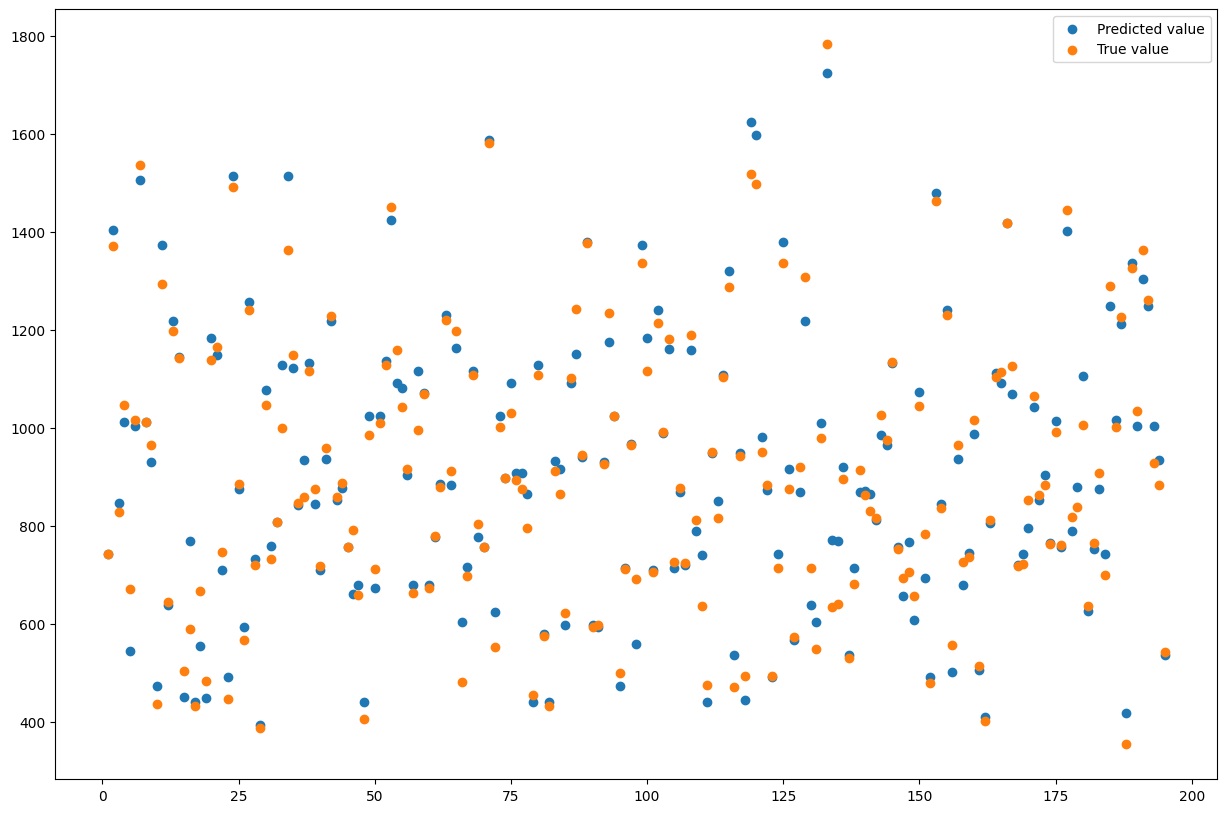

In [35]:
plot_p_vs_v(predicted, Y_validate)

In [36]:
dt_model = XGBRegressor()
dt_model.fit(X_train, Y_train)
predicted = dt_model.predict(X_validate)
print("Root Mean Squared Error:", rmse(predicted, Y_validate))
print("Mean Absolute Percentage Error (MAPE):", mape(predicted, Y_validate))

Root Mean Squared Error: 22.429858196397007
Mean Absolute Percentage Error (MAPE): 2.007689243908553


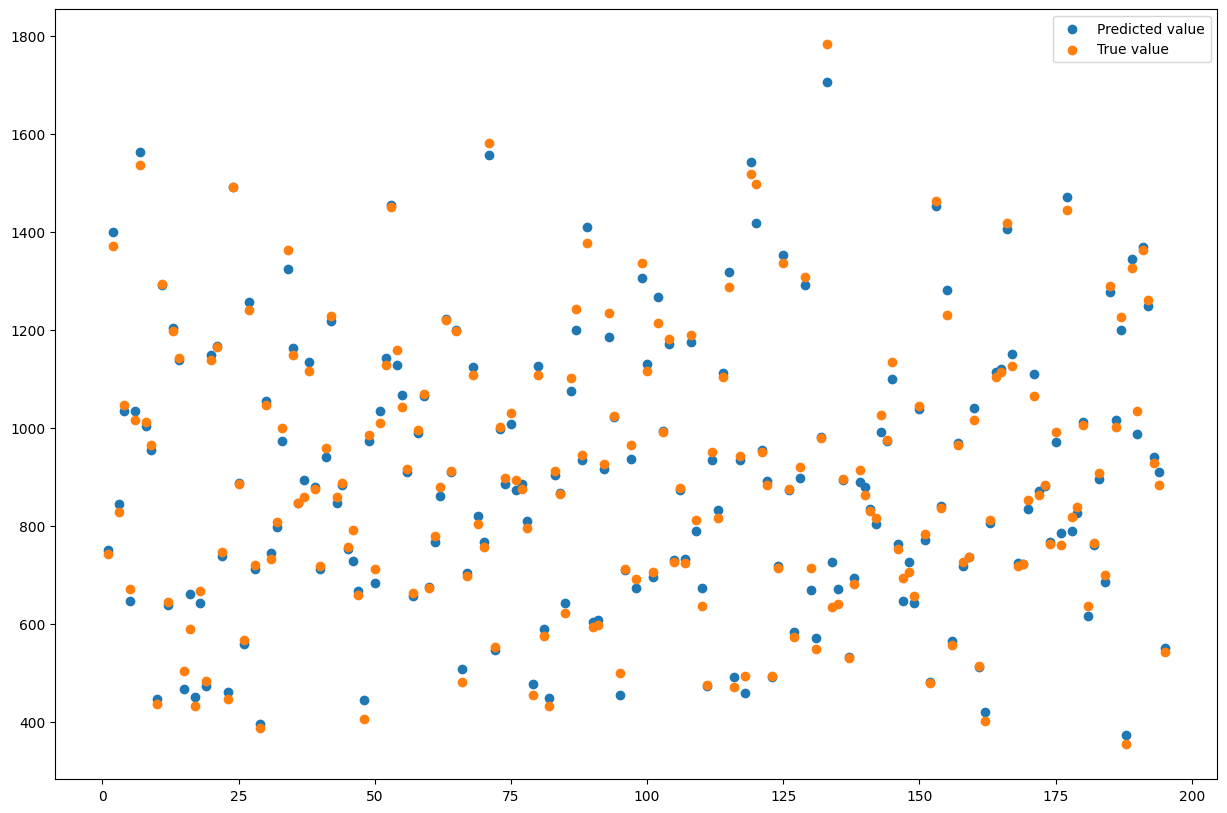

In [37]:
plot_p_vs_v(predicted, Y_validate)

In [38]:
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_validate, label=Y_validate, reference=train_data)

params = {
    "objective": "regression",  # Regression task
    "boosting_type": "gbdt",    # Gradient Boosting Decision Tree
    "metric": "rmse",           # Metric to optimize (Root Mean Squared Error)
    "num_leaves": 31,           # Max number of leaves in one tree
    "learning_rate": 0.01,      # Learning rate
    "feature_fraction": 0.9,     # Fraction of features to use per iteration
    "verbosity": -1

}

num_round = 10000
bst = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[train_data, test_data]
)

predicted = bst.predict(X_validate)

print("Root Mean Squared Error:", rmse(Y_validate, predicted))
print("Mean Absolute Percentage Error (MAPE):", mape(predicted, Y_validate))

Root Mean Squared Error: 18.188940463896174
Mean Absolute Percentage Error (MAPE): 1.481473285824159


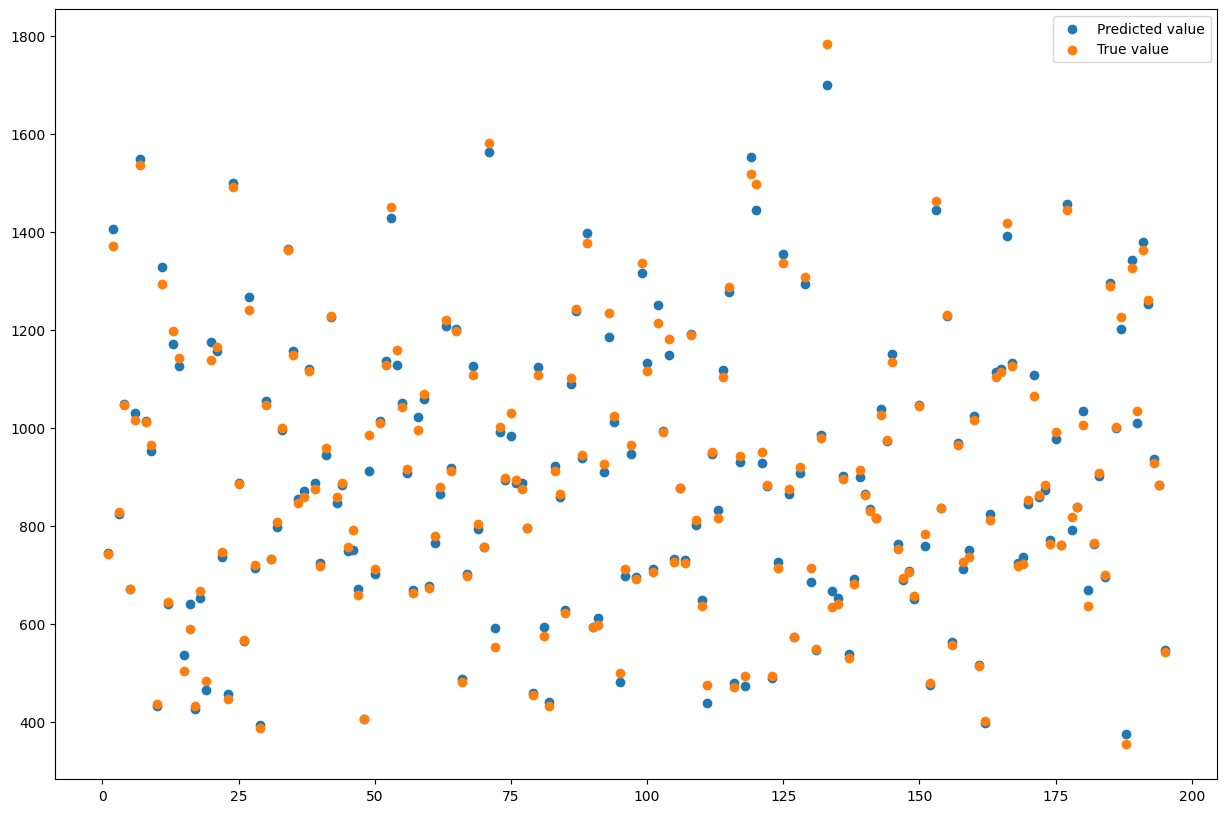

In [39]:
plot_p_vs_v(predicted, Y_validate)